Recreate this chart in Plotnine

https://github.com/adamribaudo/storytelling-with-data-ggplot/blob/master/FIG0902.R

In [1]:
#pip install plotnine

## Import libraries
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import transforms
import pandas as pd
from pandas import CategoricalDtype


#import seaborn as sns
#from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
import pandas as pd
import plotnine
%matplotlib inline

from  mizani import formatters # for better axis labelling
from matplotlib.patches import Rectangle


In [2]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [118]:
def color_title(labels, colors, textprops = {'size':'large'}, ax = None, y = 1.013,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors. Don't change axes limits afterwards."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

In [3]:
# empathy87 on github

def rainbow_text(x, y, text, colors, spacing=20, ax=None, **kw):
    colors = list(reversed(colors))
    t = ax.transData
    canvas = ax.figure.canvas

    for i, line in enumerate(reversed(text.split('\n'))):
        strings = line.split('||')
        for s, c in zip(strings, colors[i]):
            text = ax.text(x, y, s, color=c, transform=t, **kw)
            text.draw(canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, 
                                       units='dots')

        t = transforms.offset_copy(ax.transData, x=0, y=(i + 1) * spacing, 
                                   units='dots')
        

In [4]:
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

#### Read in and process the data

In [5]:

#df = pd.read_csv ( 'Data\FIG0902.csv')

fileURL = 'https://raw.githubusercontent.com/steed360/Data-Wrangling-And-Visualisation-Toolkits/main/Data%20Visualisation/Plotnine/Data/data/FIG0902.csv' 

df = pd.read_csv ( fileURL)

# Unpivot the columns 'Bottom box', 'Middle', 'Top box'
df = pd.melt (df.reset_index(), 
    id_vars = 'item', 
    value_vars = ['Bottom box', 'Middle', 'Top box'] ,
    value_name='Percentage', var_name='Answer' )

df['Percentage'] = df['Percentage'].apply (lambda x: str(x).replace  ('%', '') ).astype(int) / 100
#df[ df.item == 'Survey item D']
df.head ()

,item,Answer,Percentage
0,Survey item A,Bottom box,0.01
1,Survey item B,Bottom box,0.05
2,Survey item C,Bottom box,0.08
3,Survey item D,Bottom box,0.11
4,Survey item A,Middle,0.66


In [6]:
df[ df.item == 'Survey item A']


,item,Answer,Percentage
0,Survey item A,Bottom box,0.01
4,Survey item A,Middle,0.66
8,Survey item A,Top box,0.33


In [57]:
# Get the column label text

df['value_label'] = ''
boolIndex =  ( (df['Answer']=='Bottom box') & (df['item'] != 'Survey item A') ) |   (df['Answer']=='Top box')
df.loc [   boolIndex , 'value_label' ]  = df['Percentage']
df['value_label'] = pd.to_numeric (df['value_label']) 

df['value_label_a'] = ''
boolIndex =   (df['Answer']=='Bottom box') & (df['item'] == 'Survey item A') 
df.loc [   boolIndex , 'value_label_a' ]  = df['Percentage']
df['value_label_a'] = pd.to_numeric (df['value_label_a']) 



In [58]:
# Sort the order of the chart
# Column bars are plotted from the top down 
df['Answer'] = df.Answer.astype (CategoricalDtype(ordered=True))
df['Answer'] = df['Answer'].cat.reorder_categories(['Top box', 'Middle', 'Bottom box'])


In [59]:
df['item'] = df.item.astype (CategoricalDtype(ordered=True))
lstCats = [i for i in df['item'].unique()] # A,B,C,D (alphabetical)
df['item'] = df['item'].cat.reorder_categories( lstCats  )

# Could use format_string in geom_text but this shows nan% in the chart and I don't know how to get 
# rid of those.
df['value_label'] = df['value_label'].map ('{:.0%}'.format ).astype ('str').str.replace ('nan%', '')
df['value_label_a'] = df['value_label_a'].map ('{:.0%}'.format ).astype ('str').str.replace ('nan%', '')



,item,Answer,Percentage,value_label,value_label_a
0,Survey item A,Bottom box,0.01,,1%
1,Survey item B,Bottom box,0.05,5%,
2,Survey item C,Bottom box,0.08,8%,
3,Survey item D,Bottom box,0.11,11%,
4,Survey item A,Middle,0.66,,
5,Survey item B,Middle,0.83,,
6,Survey item C,Middle,0.83,,
7,Survey item D,Middle,0.80,,
8,Survey item A,Top box,0.33,33%,
9,Survey item B,Top box,0.12,12%,


In [10]:
df

,item,Answer,Percentage,value_label,value_label_a
0,Survey item A,Bottom box,0.01,NaN,0.01
1,Survey item B,Bottom box,0.05,0.05,NaN
2,Survey item C,Bottom box,0.08,0.08,NaN
3,Survey item D,Bottom box,0.11,0.11,NaN
4,Survey item A,Middle,0.66,NaN,NaN
5,Survey item B,Middle,0.83,NaN,NaN
6,Survey item C,Middle,0.83,NaN,NaN
7,Survey item D,Middle,0.80,NaN,NaN
8,Survey item A,Top box,0.33,0.33,NaN
9,Survey item B,Top box,0.12,0.12,NaN


In [132]:
def SWD_theme ():

    # Basic information from the 
    
    font = "Arial"
    t=theme_minimal(base_size = 10, base_family = font ) 

    t2 = theme(
      panel_grid_major = element_blank(),
      panel_grid_minor = element_blank(),

      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),

      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
        
      axis_title = element_text(color = GRAY3),

      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),

      plot_title = element_text(color = GRAY4, size= 12 ),
        
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
        
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",

      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      plot_margin = (0.1 ),  
        
      strip_text = element_text(color = GRAY7)) 
    
    return t+ t2


/usr/local/lib/python3.8/dist-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_y_continuous could not recognise parameter `position`


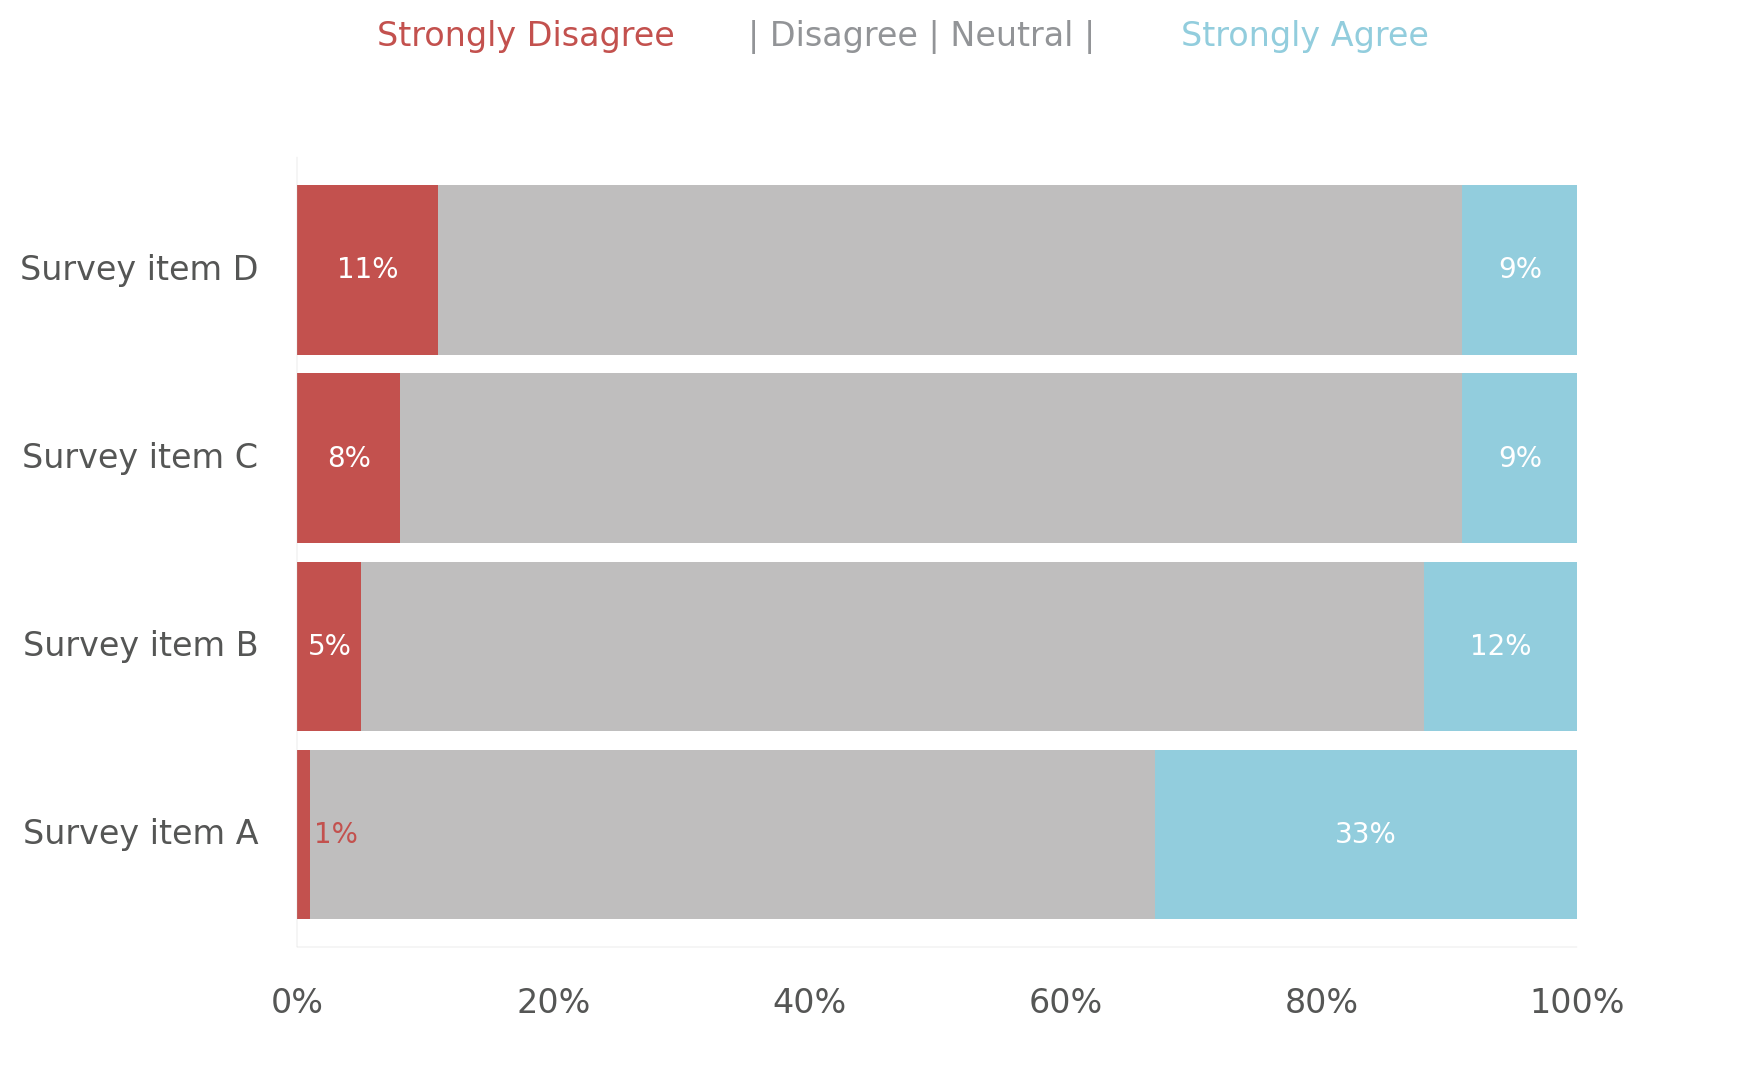

In [140]:
t = theme(         
          # Overrides
          #axis_title_y = element_text(angle = 90, va = 'top', ha = 'left', size = 15, color = GRAY3, y = 0.52),
          axis_title_y = element_text(angle = 90, va = 'top', ha = 'left', size = 15, color = GRAY3, y = 0.52),          
          panel_grid_major_y=element_blank() ,
          axis_title_x=element_blank()           
)

fig = ( ggplot(aes(x = 'item', y = 'Percentage', fill = 'Answer'), data=df ) +

  geom_col()  + 

  scale_y_continuous(position = "top",
                     labels = formatters.percent_format(),
                     breaks = [0,.2,.4, .6 , .8,  1],
                     expand = [0,0])  +

  scale_fill_manual(guide = False, 
                    values = [BLUE5,GRAY9,RED1]) + 
       
  geom_text ( aes(label = ( 'value_label'  )  ), 
            position = position_stack(vjust = 0.5),
            color = "white", size = 10 ) +

  geom_text ( aes(label = ( 'value_label_a'  )  ), 
            position = position_stack(vjust = 0.9),
            color = RED1, size = 10, nudge_y=0.02 ) +

  coord_flip() + 
  SWD_theme () + t + 

  labs ( y='Percent of Total',x= '') 
       
).draw(show=False, return_ggplot=False)

# Having got the plot make some other annotations.
ax1 = fig.axes[0]

ax0 = fig.add_axes( (0,0,1,1))
ax0.axis('Off') # don't draw anything.


cols  = [RED1,GRAY7,BLUE5]
words = ['Strongly Disagree', '| Disagree | Neutral |', 'Strongly Agree']
color_title ( colors=cols, labels= words)

fig.dpi = 200
width_in = 8
fig.set_size_inches(width_in , width_in/1.62) 
